In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as mtick
from scipy.stats import jarque_bera

In [2]:
rates=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical rates', header=1)
portfolio=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical portfolio', header=1)

In [3]:
ftp=rates.iloc[:,:6]
euribor=rates.iloc[:,7:]

In [4]:
new_column_names = {'3Y.1': '3Y', '5Y.1': '5Y', '10Y.1': '10Y'}

# Rename columns
euribor.rename(columns=new_column_names, inplace=True)

#### Test for normality

In [7]:
# Perform Jarque-Bera test for normality
jb_test_statistic, jb_p_value = jarque_bera(euribor.iloc[:,1:].values)

print("Jarque-Bera statistic:", jb_test_statistic)
print("p-value:", jb_p_value)

# Set significance level for the test
alpha = 0.05

if jb_p_value > alpha:
    print("The portfolio loss returns are normally distributed (fail to reject H0).")
else:
    print("The portfolio loss returns are not normally distributed (reject H0).")


Jarque-Bera statistic: 146.42099424814194
p-value: 0.0
The portfolio loss returns are not normally distributed (reject H0).


<ipython-input-8-a6fa8802cc8e>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_yield = euribor.mean(axis=0)


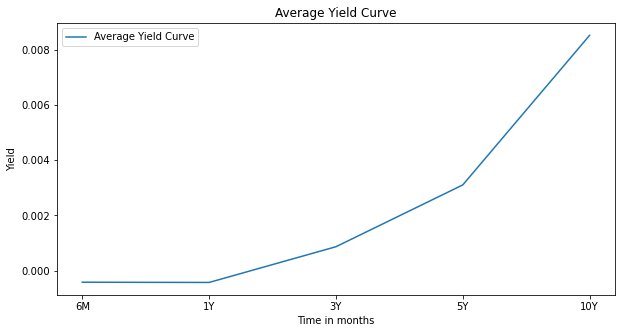

In [8]:
# STYLIZED FACT 1
# Calculate the average yield for each maturity
average_yield = euribor.mean(axis=0)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(euribor.columns[1:], average_yield, label='Average Yield Curve')

plt.xlabel('Time in months')
plt.ylabel('Yield')
plt.title('Average Yield Curve')

plt.legend()

plt.show()

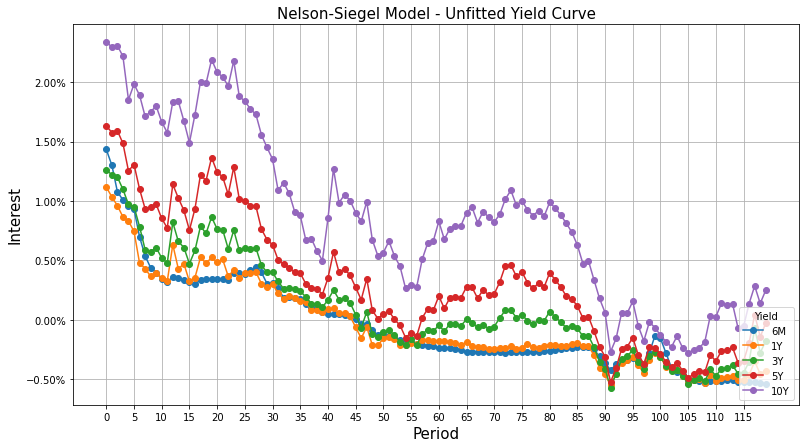

In [9]:
sf = euribor.copy()
sf = sf.dropna()
sf1 = sf.copy()
sf1['Y'] = round(sf['6M']*100, 4)

# Define columns to plot
columns_to_plot = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Plotting
fig, ax = plt.subplots(figsize=(13, 7))
plt.title("Nelson-Siegel Model - Unfitted Yield Curve", fontsize=15)
#ax.set_facecolor("black")
#fig.patch.set_facecolor('white')

# Plot each column
for col in columns_to_plot:
    X = sf1.index
    Y = sf1[col] * 100  # Convert to percentage
    plt.plot(X, Y, label=f"{col}", marker="o")

plt.xlabel('Period', fontsize=15)
plt.ylabel('Interest', fontsize=15)
plt.xticks(np.arange(0, 120, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Yield", loc="lower right")
plt.grid()
plt.show()

In [129]:
from scipy.stats import t

# Assuming euribor is your DataFrame containing the data

# Fit the t-distribution to each column of the DataFrame
t_distribution_params = euribor.iloc[:,1:].apply(t.fit)

# Display the parameters of the fitted t-distribution
print(t_distribution_params)

         6M        1Y            3Y            5Y           10Y
0  2.545156  2.537589  2.576854e+06  2.443535e+06  6.931053e+06
1 -0.001491 -0.001473  8.647791e-04  3.106323e-03  8.530697e-03
2  0.002824  0.002810  4.363285e-03  5.407080e-03  7.218350e-03


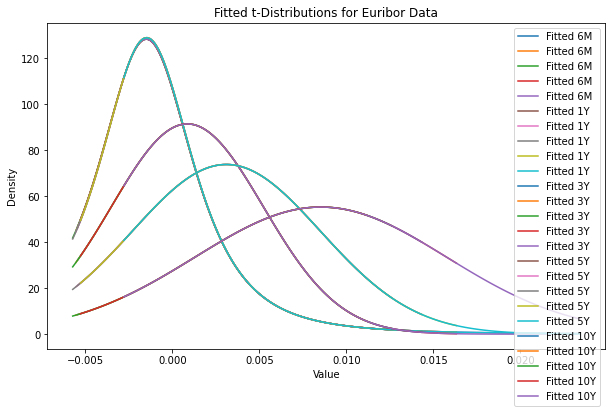

In [155]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# Assuming euribor is your DataFrame containing the data
# Assuming t_distribution_params is the DataFrame containing the fitted t-distribution parameters

# Number of points for plotting
num_points = len(euribor)

# Create an array of x values
x_values = np.linspace(euribor.iloc[:,1:].min(), euribor.iloc[:,1:].max(), num_points)

# Plot the original data
plt.figure(figsize=(10, 6))
#for col in euribor.columns:
    #plt.hist(euribor[col], bins=50, density=True, alpha=0.5, label=f'Original {col}')

# Plot the fitted t-distributions
for col in t_distribution_params.columns:
    params = t_distribution_params[col]
    pdf_values = t.pdf(x_values, *params)
    plt.plot(x_values, pdf_values, label=f'Fitted {col}')

plt.title('Fitted t-Distributions for Euribor Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [149]:
t_distribution_params.columns

Index(['6M', '1Y', '3Y', '5Y', '10Y'], dtype='object')

In [ ]:
dof6M= t_distribution_params.iloc[0,0]
degrees of freedom, location, and scale

In [60]:
# STYLIZED FACT 3-5
# voor het maken van de tabel om de stylized facts te checken met autocorrelation
def lagSeries(column, lag):
    return column.shift(lag)

def autoCorrelation(series, lag):
    lag_series = lagSeries(series, lag)
    return series.corr(lag_series)

def makeTable():
    table = []
    maturities = ['6M','1Y','3Y','5Y','10Y']
    for maturity in maturities:
        series = euribor[maturity]
        row = {"maturity": maturity,
              "mean": series.mean(),
               "std": series.std(),
               "rho_1": autoCorrelation(series,1),
               "rho_6": autoCorrelation(series,6),
               "rho_12": autoCorrelation(series,12)}
        table.append(row)
    return pd.DataFrame(table)

print(makeTable().round(3))

  maturity   mean    std  rho_1  rho_6  rho_12
0       6M -0.000  0.004  0.994  0.922   0.879
1       1Y -0.000  0.004  0.985  0.925   0.918
2       3Y  0.001  0.004  0.980  0.905   0.842
3       5Y  0.003  0.005  0.978  0.882   0.762
4      10Y  0.009  0.007  0.981  0.883   0.740


In [11]:
# STYLIZED FACT 6
# Calculate cross-correlations


correlations = euribor.corr()

print(correlations)

           6M        1Y        3Y        5Y       10Y
6M   1.000000  0.978877  0.945785  0.906102  0.869265
1Y   0.978877  1.000000  0.983605  0.954711  0.924067
3Y   0.945785  0.983605  1.000000  0.990970  0.968453
5Y   0.906102  0.954711  0.990970  1.000000  0.989733
10Y  0.869265  0.924067  0.968453  0.989733  1.000000


In [12]:
# Function to calculate cross-correlation with optional lag
def crossCorrelation(series1, series2, lag=0):
    lag_series = series2.shift(lag)
    return series1.corr(lag_series)
crossCorrelation(euribor['1Y'], euribor['3Y'], lag=0)

0.9836051135888911

### Dynamic Nelson Siegel

In [338]:
def create_ns_matrix(tau, lamb):
    tau = np.atleast_1d(tau)
    lamb = np.atleast_1d(lamb)
    ns_matrix = np.zeros((len(tau), 3))

    for i in range(len(tau)):
        ns_matrix[i, 0] = 1
        ns_matrix[i, 1] = (1 - np.exp(-lamb * tau[i])) / (lamb * tau[i])
        ns_matrix[i, 2] = ns_matrix[i, 1] - np.exp(-lamb * tau[i])

    ns_df = pd.DataFrame(ns_matrix, columns=['1', '(1-e^-λτ)/λτ', '(1-e^-λτ)/λτ - e^-λτ'])
    return ns_df

def estimate_betas(Y, tau_example, lambda_example):
    B = create_ns_matrix(tau_example, lambda_example)
    BBi = np.linalg.inv(B.T @ B)
    betas = np.linalg.inv(B.T @ B) @ B.T @ Y.T

    beta1 = betas.iloc[0, :]
    beta2 = betas.iloc[1, :]
    beta3 = betas.iloc[2, :]

    cs = []
    phis = []

    for beta in [beta1, beta2, beta3]:
        beta_lagged = beta[:-1].values
        beta_current = beta[1:].values
        beta_lagged_with_constant = sm.add_constant(beta_lagged)
        model = sm.OLS(beta_current, beta_lagged_with_constant)
        results = model.fit()

        c_estimate = results.params[0]
        phi_estimate = results.params[1]

        cs.append(c_estimate)
        phis.append(phi_estimate)

    beta1s = list(beta1.values)
    beta1_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta1s.append(cs[0] + phis[0] * beta1s[-1])
        beta1_np[i] = cs[0] + phis[0] * beta1s[-1]

    beta2s = list(beta2.values)
    beta2_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta2s.append(cs[1] + phis[1] * beta2s[-1])
        beta2_np[i] = cs[1] + phis[1] * beta2s[-1]

    beta3s = list(beta3.values)
    beta3_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta1s.append(cs[2] + phis[2] * beta3s[-1])
        beta3_np[i] = cs[2] + phis[2] * beta3s[-1]

    betas = np.row_stack((beta1_np, beta2_np, beta3_np))
    return B, betas

# Sample data setup
train_data = euribor.iloc[:96, 1:]
test_data = euribor.iloc[96:, 1:]

# Define maturities
maturities = ["6M", "1Y", "3Y", "5Y", "10Y"]
Y = train_data.values

# Estimate betas
tau_example = np.array([6, 12, 36, 60, 120])
def find_optimal_lambda(train_data, test_data, tau_example, lambda_range):
    min_mse = float('inf')
    optimal_lambda = None

    for lambda_val in lambda_range:
        B, betas = estimate_betas(train_data.values, tau_example, lambda_val)
        y = B @ betas

        mse_values = []

        for j in range(len(test_data)):
            forecast_y = y.iloc[:, j]
            real_y = test_data.iloc[j, :]
            squared_diff = (forecast_y - real_y.values) ** 2
            mse = np.mean(squared_diff)
            mse_values.append(mse)

        avg_mse = np.mean(mse_values)

        if avg_mse < min_mse:
            min_mse = avg_mse
            optimal_lambda = lambda_val

    return optimal_lambda, min_mse

# Define the range of lambda values to search over
lambda_range = np.arange(0.1, 3.0, 0.1)

# Call the function to find the optimal lambda
optimal_lambda, min_mse = find_optimal_lambda(train_data, test_data, tau_example, lambda_range)

print("Optimal Lambda:", optimal_lambda)
print("Minimum Mean Squared Error:", min_mse)


Optimal Lambda: 0.1
Minimum Mean Squared Error: 6.226835877852261e-06


In [339]:
lambda_example = 0.1      # Replace with desired λ value
tau_example = np.array([6, 12, 36, 60, 120])
Y = train_data.values
B, betas = estimate_betas(Y, tau_example, lambda_example)
y = B@betas


In [340]:
y=y.T
new_column_names = {0: '6M', 1: '1Y', 2: '3Y', 3:'5Y', 4:'10Y'}

# Rename columns
y.rename(columns=new_column_names, inplace=True)
y=y.set_index(test_data.index)


No handles with labels found to put in legend.


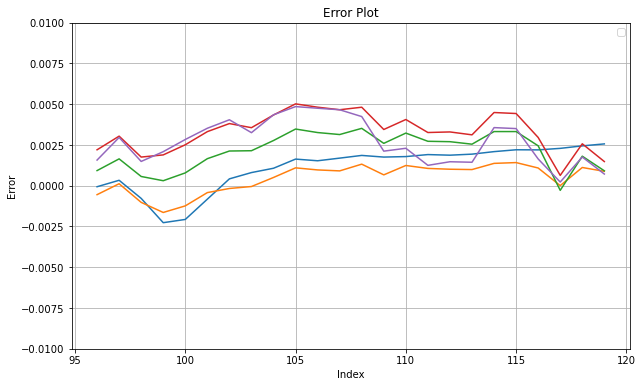

In [341]:
# Calculate the error
error = y - test_data

# Plot the error
plt.figure(figsize=(10, 6))
plt.plot(error)
plt.title('Error Plot')
plt.xlabel('Index')
plt.ylabel('Error')
plt.ylim(-0.01, 0.01)
plt.legend()
plt.grid(True)
plt.show() 


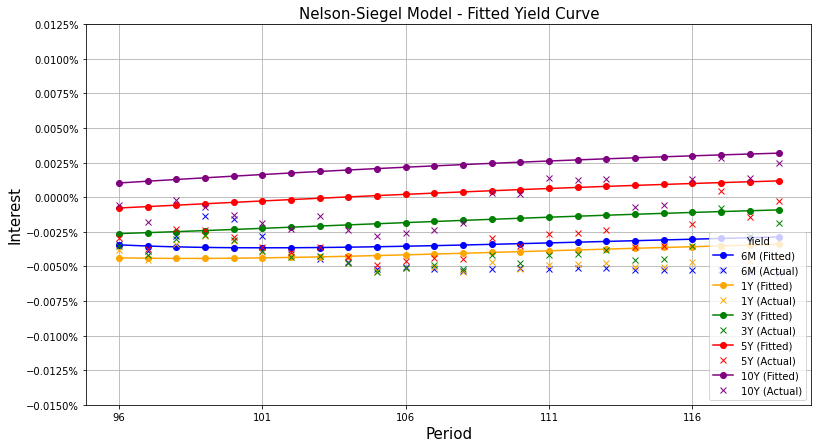

In [342]:
# Create a copy of the transposed DataFrame
sf = y.copy()

# Drop any rows with missing values
sf = sf.dropna()

# Create a copy of the DataFrame sf
sf1 = sf.copy()

# Multiply by 100 to convert to percentage and round to 4 decimal places
sf1['Y'] = round(sf1['6M'] * 100, 4)

# Define columns to plot
columns_to_plot = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Plotting
fig, ax = plt.subplots(figsize=(13, 7))
plt.title("Nelson-Siegel Model - Fitted Yield Curve", fontsize=15)
#ax.set_facecolor("black")
#fig.patch.set_facecolor('white')

# Define colors for each column
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plot each column from sf1 and test_data
for idx, col in enumerate(columns_to_plot):
    X = sf1.index
    Y = sf1[col]  # Fitted data
    plt.plot(X, Y, label=f"{col} (Fitted)", marker="o", color=colors[idx])
    
    i = test_data.index
    k = test_data[col]  # Test data for the same maturity
    plt.plot(i, k, marker='x', linestyle='None', label=f"{col} (Actual)", color=colors[idx])

plt.xlabel('Period', fontsize=15)
plt.ylabel('Interest', fontsize=15)
plt.xticks(np.arange(96, 120, 5))
plt.yticks(np.arange(-0.015, 0.015, 0.0025))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Yield", loc="lower right")
plt.grid()
plt.show()


### Random walk

In [343]:
#benchmark random walk
def random_walk(series, months):
    k = series.iloc[-1]
    return k

maturities = ["6M", "1Y", "3Y", "5Y", "10Y"]

Y = train_data

Y = Y.values

forecast_results_df = pd.DataFrame(index=maturities, columns=range(1, 25))

for maturity in maturities:
    series = train_data[maturity]

    for horizon in range(1, 25):
        forecast_key = f'Maturity_{maturity}Horizon{horizon}'

        # Expanding window forecast

        forecast = random_walk(series, horizon)

        forecast_results_df.loc[maturity, horizon] = forecast

In [351]:
forecast_results_df=forecast_results_df.T
forecast_results_df=forecast_results_df.set_index(test_data.index)
forecast_results_df

,6M,1Y,3Y,5Y,10Y
96,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
97,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
98,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
99,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
100,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
101,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
102,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
103,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
104,-0.00325,-0.003165,-0.00257,-0.001525,0.00153
105,-0.00325,-0.003165,-0.00257,-0.001525,0.00153


In [353]:
MSE2=mean_squared_error(test_data, forecast_results_df)
print(f"The mean MSE RW",MSE2)

The mean MSE RW 3.6938821416666664e-06


In [368]:
# Define the index range
index_range = range(24)

# Define the column names
column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Create the DataFrame
e = pd.DataFrame(index=index_range, columns=column_names)
e.iloc[:,0]=(test_data.iloc[:,0]-forecast_results_df.iloc[:,0]).values
e.iloc[:,1]=(test_data.iloc[:,1]-forecast_results_df.iloc[:,1]).values
e.iloc[:,2]=(test_data.iloc[:,2]-forecast_results_df.iloc[:,2]).values
e.iloc[:,3]=(test_data.iloc[:,3]-forecast_results_df.iloc[:,3]).values
e.iloc[:,4]=(test_data.iloc[:,4]-forecast_results_df.iloc[:,4]).values



In [403]:
e = e.apply(pd.to_numeric, errors='coerce')

In [451]:
# STYLIZED FACT 3-5
# voor het maken van de tabel om te checken of er hoge autocorrelation is
def lagSeries(column, lag):
    return column.shift(lag)

def autoCorrelation(series, lag):
    lag_series = lagSeries(series, lag)
    if len(series) != len(lag_series):
        raise ValueError("Length mismatch between series and lagged series")
    return series.corr(lag_series)

def makeTable():
    table = []
    maturities = ['6M','1Y','3Y','5Y','10Y']
    for maturity in maturities:
        series = res[maturity]
        row = {"maturity": maturity,
              "mean": series.mean(),
               "std": series.std(),
               "rho_1": autoCorrelation(series,1),
               "rho_6": autoCorrelation(series,6),
               "rho_12": autoCorrelation(series,12)}
        table.append(row)
    return pd.DataFrame(table)

print(makeTable().round(3))

  maturity  mean    std  rho_1  rho_6  rho_12
0       6M  -0.0  0.001  0.378 -0.559  -0.116
1       1Y  -0.0  0.001 -0.061 -0.211  -0.584
2       3Y  -0.0  0.001 -0.088  0.008  -0.552
3       5Y   0.0  0.001 -0.048  0.129  -0.471
4      10Y   0.0  0.001  0.028  0.093  -0.366


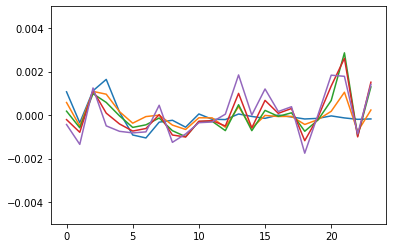

In [406]:
#plt.plot(ar1_results[col].resid)
for i in e.columns:
    plt.plot(ar1_results[i].resid)
    plt.ylim(-0.005, 0.005)

In [445]:
# Assume 'residuals' is a pandas DataFrame with columns representing different maturities
residuals= e
# Fit AR(1) models to each column (maturity) of residuals
ar1_results = {}
for col in residuals.columns:
    model = sm.tsa.ARIMA(residuals[col], order=(1, 0, 0))
    ar1_results[col] = model.fit()

    
# Define the index range
index_range = range(24)

# Define the column names
column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Create the DataFrame
res = pd.DataFrame(index=index_range, columns=column_names)
# Check for normality of residuals using Shapiro-Wilk test for each maturity
shapiro_p_values = {}
for col, result in ar1_results.items():
    res[col] = result.resid
  

/Users/amiraouazade/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Summary of Estimates for Skew-Normal distribution:
  Maturity      Mean   Std_Dev          Skew
0       6M -0.000613  0.000811  2.484664e+00
1       1Y -0.000724  0.000875  1.230510e+01
2       3Y -0.000992  0.001298  4.657245e+07
3       5Y -0.001177  0.001501  4.426970e+07
4      10Y -0.001265  0.001646  3.745284e+00


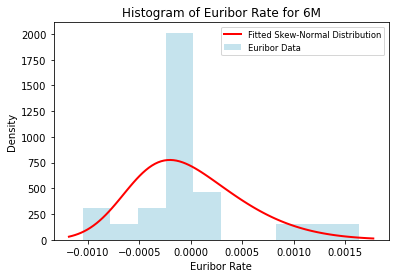

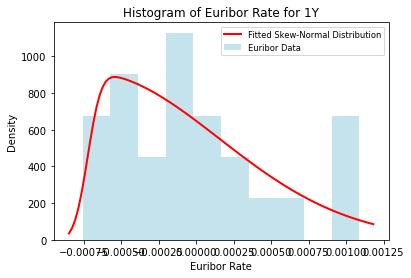

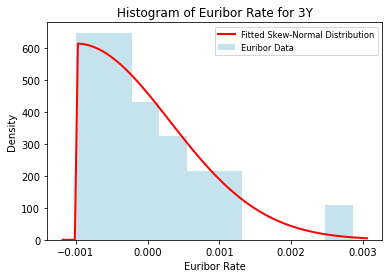

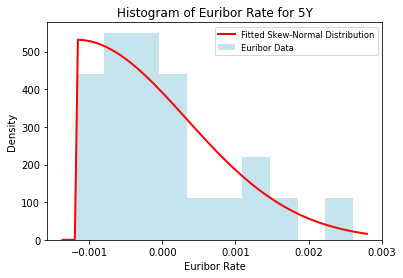

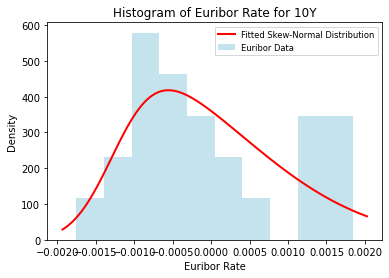

In [446]:
# Create an empty dataframe to store mean and standard deviation of estimates
fit_summary_skew = pd.DataFrame(columns=["Maturity", "Mean", "Std_Dev", "Skew"])

# Iterate over each maturity
for maturity in euribor.columns[1:]:
    # Fit a skew-normal distribution to the Euribor data
    fit_params_skew = stats.skewnorm.fit(res[maturity])
    
    # Summary of the fitted distribution
    #print("Summary for", maturity)
    #print("Mean:", fit_params_skew[1])
    #print("Standard Deviation:", fit_params_skew[2])
    #print("Skewness:", fit_params_skew[0])
    
    # Save mean, standard deviation, and skewness of estimates
    fit_summary_skew = fit_summary_skew.append({"Maturity": maturity, "Mean": fit_params_skew[1], "Std_Dev": fit_params_skew[2], "Skew": fit_params_skew[0]}, ignore_index=True)
    
    # Plot histogram of Euribor data for the current maturity
    plt.figure()
    plt.hist(res[maturity], bins=10, color='lightblue', alpha=0.7, density=True)
    plt.title("Histogram of Euribor Rate for " + maturity)
    plt.xlabel("Euribor Rate")
    plt.ylabel("Density")
    
    # Plot fitted skew-normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.skewnorm.pdf(x, fit_params_skew[0], fit_params_skew[1], fit_params_skew[2])
    plt.plot(x, p, 'red', linewidth=2)
    
    # Add legend with smaller text size
    plt.legend(["Fitted Skew-Normal Distribution", "Euribor Data"], loc="upper right", fontsize="small")

# View the summary of estimates for skew-normal distribution
print("Summary of Estimates for Skew-Normal distribution:")
print(fit_summary_skew)

In [479]:
from scipy.stats import gamma, skewnorm
import numpy as np
for i in range(0,5):
    # Assuming your data is stored in 'data'
    data = res.iloc[:,i]

    # Fit gamma distribution
    params_gamma = gamma.fit(data)

    # Fit skew-normal distribution
    params_skewnorm = skewnorm.fit(data)

    params_t=t.fit(data)
    
    params_norm= stats.norm.fit(data)
    
    # Calculate AIC or BIC for gamma distribution
    aic_gamma = -2 * gamma.logpdf(data, *params_gamma).sum() + 2 * len(params_gamma)

    # Calculate AIC or BIC for skew-normal distribution
    aic_skewnorm = -2 * skewnorm.logpdf(data, *params_skewnorm).sum() + 2 * len(params_skewnorm)
    
    aic_t = -2 * t.logpdf(data, *params_gamma).sum() + 2 * len(params_gamma)

    aic_norm = -2 * stats.norm.logpdf(data, *params_norm).sum() + 2 * len(params_gamma)

    
    # Compare AIC or BIC values
    if aic_gamma < aic_skewnorm:
        print("Gamma distribution is a better fit.")
    else:
        print("Skew-normal distribution is a better fit.")
        
    print(aic_gamma, aic_skewnorm, aic_t, aic_norm)


Skew-normal distribution is a better fit.
-248.47796918697955 -288.2635548080083 125.61073413275689 -284.2054591572024
Skew-normal distribution is a better fit.
-294.1517311322326 -294.32397444460014 -239.08593051142245 -289.32177486368096
Gamma distribution is a better fit.
-302.4641510281989 -278.2024416803812 -211.20601909469565 -265.65506303159594
Skew-normal distribution is a better fit.
-270.1437154502682 -271.23182854032063 -230.81080284354235 -261.28336807017774
Skew-normal distribution is a better fit.
-257.51445578621895 -257.832169103909 -33.737280604720375 -255.77574262925538


In [480]:
for i in res.columns:
# Fit the skew-normal distribution to your data
    fit_params = skewnorm.fit(res[i])

    # Perform the KS test
    statistic, p_value = kstest(res[i], 'skewnorm', fit_params)

    # Print the results
    print("KS Statistic:", statistic)
    print("P-value:", p_value)

KS Statistic: 0.24429474637696036
P-value: 0.09550934282659718
KS Statistic: 0.12875553677218388
P-value: 0.7746924276778058
KS Statistic: 0.10227501133208505
P-value: 0.9413713054276915
KS Statistic: 0.10714080231541023
P-value: 0.9184962190738439
KS Statistic: 0.11595670709081607
P-value: 0.8670698228561621


In [478]:
from scipy.stats import kstest, norm
fit_params = t.fit(res['6M'])
# Perform the KS test for a normal distribution
statistic, p_value = kstest(res['6M'], 't', fit_params)

# Print the results
print("KS Statistic:", statistic)
print("P-value:", p_value)


KS Statistic: 0.1325120482105257
P-value: 0.7448509731636499


In [448]:
fit_params

(2.48466394257206, -0.0006128072212666915, 0.0008105564788674388)

In [467]:
# Save the DataFrame to an Excel file
res.to_excel("eta_data.xlsx", index=False)
e.to_excel("error_term.xlsx", index=False) # y_obs-y_test

/Users/amiraouazade/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Shapiro-Wilk test p-value for 6M: 0.0005059079267084599
Shapiro-Wilk test p-value for 1Y: 0.0642082691192627
Shapiro-Wilk test p-value for 3Y: 0.0029706612695008516
Shapiro-Wilk test p-value for 5Y: 0.0312725193798542
Shapiro-Wilk test p-value for 10Y: 0.13776972889900208


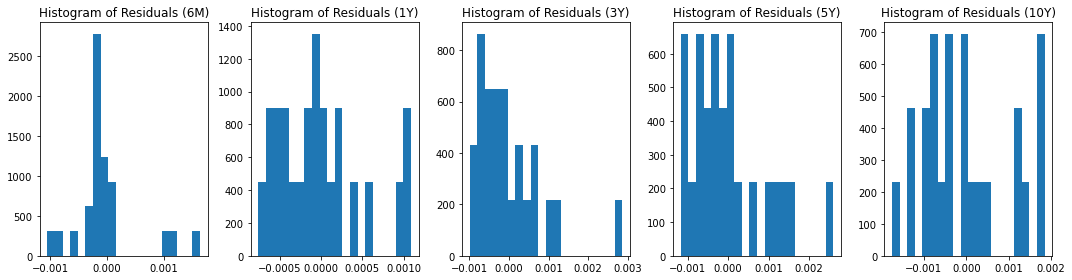

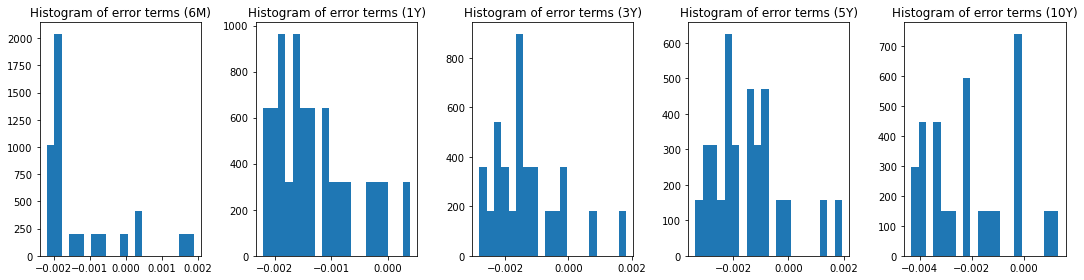

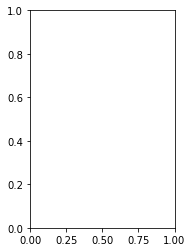

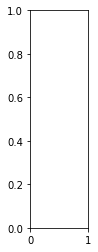

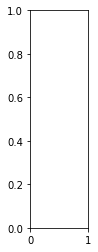

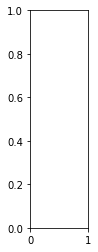

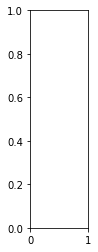

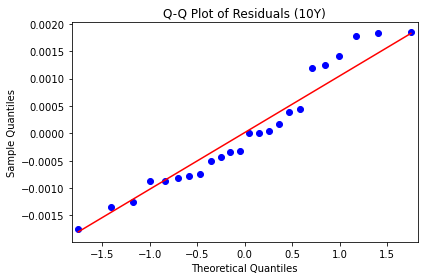

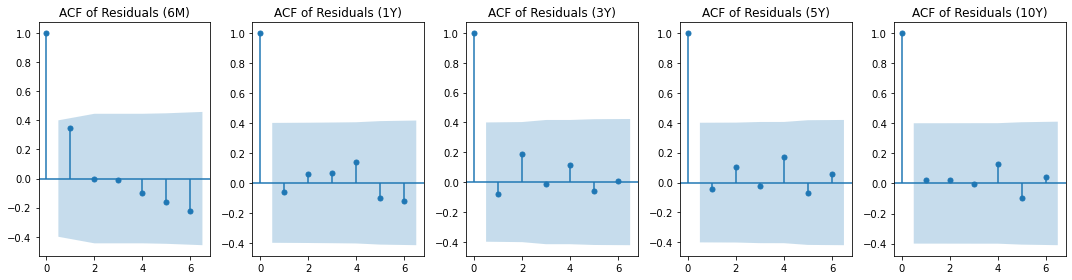

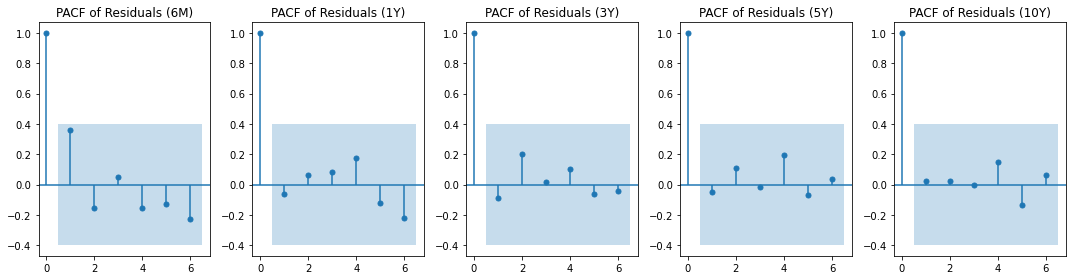

In [405]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Assume 'residuals' is a pandas DataFrame with columns representing different maturities
residuals= e
# Fit AR(1) models to each column (maturity) of residuals
ar1_results = {}
for col in residuals.columns:
    model = sm.tsa.ARIMA(residuals[col], order=(1, 0, 0))
    ar1_results[col] = model.fit()

# Check for normality of residuals using Shapiro-Wilk test for each maturity
shapiro_p_values = {}
for col, result in ar1_results.items():
    shapiro_stat, shapiro_p_values[col] = shapiro(result.resid)
    print(f"Shapiro-Wilk test p-value for {col}:", shapiro_p_values[col])

# Plot histogram and Q-Q plot of residuals for each maturity
plt.figure(figsize=(15, 4))
for i, col in enumerate(residuals.columns, 1):
    plt.subplot(1, len(residuals.columns), i)
    plt.hist(ar1_results[col].resid, bins=20, density=True)
    plt.title(f"Histogram of Residuals ({col})")

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 4))
for i, col in enumerate(residuals.columns, 1):
    plt.subplot(1, len(residuals.columns), i)
    plt.hist(residuals[col], bins=20, density=True)
    plt.title(f"Histogram of error terms ({col})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 4))
for i, col in enumerate(residuals.columns, 1):
    plt.subplot(1, len(residuals.columns), i)
    sm.qqplot(ar1_results[col].resid, line='s')
    plt.title(f"Q-Q Plot of Residuals ({col})")

plt.tight_layout()
plt.show()

# Check for autocorrelation of residuals for each maturity
plt.figure(figsize=(15, 4))
for i, col in enumerate(residuals.columns, 1):
    plt.subplot(1, len(residuals.columns), i)
    sm.graphics.tsa.plot_acf(ar1_results[col].resid, lags=6, ax=plt.gca())
    plt.title(f"ACF of Residuals ({col})")

plt.tight_layout()
plt.show()

# Check for partial autocorrelation of residuals for each maturity
plt.figure(figsize=(15, 4))
for i, col in enumerate(residuals.columns, 1):
    plt.subplot(1, len(residuals.columns), i)
    sm.graphics.tsa.plot_pacf(ar1_results[col].resid, lags=6, ax=plt.gca())
    plt.title(f"PACF of Residuals ({col})")

plt.tight_layout()
plt.show()


### Vasicek model

In [334]:
def getSimRate(kappa, mu, sigma, r0, R, delta, T0, T1):
    #nsteps = int(T0 / delta)
    nsteps = int(T1-T0+1)
    dVarSR = (sigma**2) * (1 - np.exp(-2 * kappa * delta)) / (2 * kappa)  # short rate variance
    mR = np.zeros((R, nsteps))

    for r in range(R):
        mR[r, 0] = r0
        for i in range(1, nsteps):
            mR[r, i] = np.exp(-kappa * delta) * mR[r, i - 1] + \
                (1 - np.exp(-kappa * delta)) * mu + \
                np.random.normal(0, np.sqrt(dVarSR))
    
    return mR

In [348]:
# Simulation parameters
R = 100     # Number of simulations (paths)
delta = 1/12  # Time step size (1 month)
T0 = 1       # Time to start of simulation
T1 = 24      # Time to end of simulation

def find_optimal_kappa(train_data, test_data, kappa_range):
    min_mse = float('inf')
    optimal_kappa = None

    for kappa_val in kappa_range:
        mse_values = []

        for column in train_data.columns:
            # Define Vasicek model parameters for each column
            mu = np.mean(train_data[column])
            sigma = np.std(train_data[column])
            r0 = train_data[column].iloc[-1]  # Initial short rate

            # Call getSimRate function to simulate short rate paths
            mR = getSimRate(kappa_val, mu, sigma, r0, R, delta, T0, T1)

            # Calculate mean squared error for the current column
            squared_diff = (np.mean(mR, axis=0) - test_data[column]) ** 2
            mse = np.mean(squared_diff)
            mse_values.append(mse)

        # Calculate average mean squared error across all columns
        avg_mse = np.mean(mse_values)

        # Update optimal kappa and min_mse if current kappa yields lower MSE
        if avg_mse < min_mse:
            min_mse = avg_mse
            optimal_kappa = kappa_val

    return optimal_kappa, min_mse

# Define the range of kappa values to search over
kappa_range = np.arange(0.1, 3.0, 0.1)

# Call the function to find the optimal kappa
optimal_kappa, min_mse = find_optimal_kappa(train_data, test_data, kappa_range)

print("Optimal kappa:", optimal_kappa)
print("Minimum Mean Squared Error:", min_mse)


Optimal kappa: 0.1
Minimum Mean Squared Error: 4.737647794282783e-06


In [243]:
# Define the index range
index_range = range(24)

# Define the column names
column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Create the DataFrame
df = pd.DataFrame(index=index_range, columns=column_names)

mse_values2=[]
kappa=0.1 # as it is the optimal
R = 1000     # Number of simulations (paths)
delta = 1/12  # Time step size (1 month)
T0 = 1       # Time to start of simulation
T1 = 24      # Time to end of simulation

for column in train_data.columns:
    
    # Define Vasicek model parameters for each maturity
    mu = np.mean(train_data[column])
    sigma = np.std(train_data[column])
    r0 = train_data[column].iloc[-1]  # Initial short rate

    # Call getSimRate function to simulate short rate paths
    mR = getSimRate(kappa, mu, sigma, r0, R, delta, T0, T1)
    r=np.mean(mR, axis=0)
    df[column]=r
    # Calculate mean squared error for the current column
    squared_diff = (r - test_data[column]) ** 2
    mse = np.mean(squared_diff)
    mse_values2.append(mse)

# Calculate average mean squared error across all columns
    avg_mse = np.mean(mse_values2)

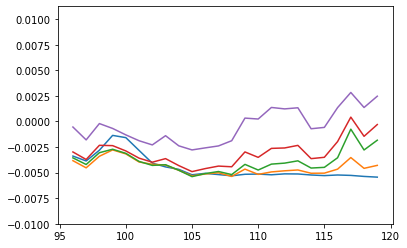

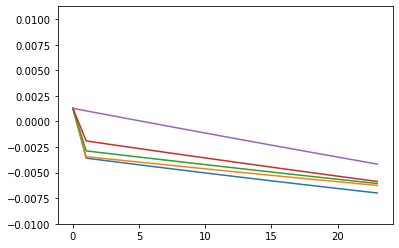

4.802997326247636e-06


In [244]:
n = len(train_data)
expected_forecast = np.zeros((len(test_data),5))
for j in range(0,5):
    a_vasi = -1 / 12 * np.log((n * sum(euribor.iloc[0: (n - 2),j+1].values * euribor.iloc[1 : (n-1), j+1].values) - sum(euribor.iloc[ 1 : (n-1),j+1].values) * sum(euribor.iloc[0: (n - 2),j+1].values))/(n * sum(euribor.iloc[0 : (n - 2),j+1]**2) - sum(euribor.iloc[0 : (n - 2),j+1])**2))
    lr_mu_vasi = 1 / (n * (1 - np.exp(-a_vasi / 12))) * (sum(euribor.iloc[1 : (n-1),j+1]) - np.exp(a_vasi / 12) * sum(euribor.iloc[0 : (n - 2),j+1]))
    var_vasi = 2 * a_vasi / (n * (1 - np.exp(-a_vasi / 6))) * sum((euribor.iloc[1 : (n-1),j+1] - euribor.iloc[0 : (n -2),j+1] * np.exp(-a_vasi/12) - lr_mu_vasi * (1 - np.exp(-a_vasi/12)))**2)
    expected_forecast[0] = train_data.iloc[-1,j] * np.exp(-a_vasi) + lr_mu_vasi * (1 - np.exp(-a_vasi / 12))
    for i in range(1, len(test_data)):
        expected_forecast[i,j] = expected_forecast[i - 1, j] * np.exp(-a_vasi) + lr_mu_vasi * (1 - np.exp(-a_vasi / 12))

# Plotting
import matplotlib.pyplot as plt

plt.plot(test_data)
plt.ylim(-0.010, 0.01125)
plt.show()

plt.plot(expected_forecast)
plt.ylim(-0.010, 0.01125)
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error

mse_vasi_paper = mean_squared_error(test_data, expected_forecast)
print(mse_vasi_paper)

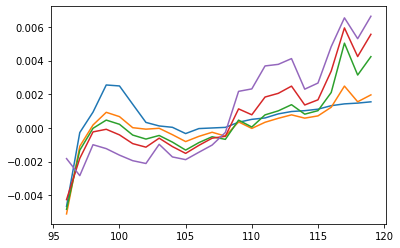

In [320]:
plt.plot(test_data-expected_forecast)

Summary for 6M
Mean: -0.0001396483737849906
Standard Deviation: 0.0001953737968663046
Degrees of Freedom: 2.041139938145573
Summary for 1Y
Mean: -0.00011321120837411551
Standard Deviation: 0.0003513557472320701
Degrees of Freedom: 2.031194775460273
Summary for 3Y
Mean: -0.00020960333720316984
Standard Deviation: 0.0005005044217693765
Degrees of Freedom: 2.0668239478740986
Summary for 5Y
Mean: -0.0002472741511672184
Standard Deviation: 0.0005988977985502381
Degrees of Freedom: 2.0808998286911278
Summary for 10Y
Mean: -0.0002001705252945715
Standard Deviation: 0.0007764949040185239
Degrees of Freedom: 2.0629244701025664
Summary of Estimates for t distribution:
  Maturity      Mean   Std_Dev        df
0       6M -0.000140  0.000195  2.041140
1       1Y -0.000113  0.000351  2.031195
2       3Y -0.000210  0.000501  2.066824
3       5Y -0.000247  0.000599  2.080900
4      10Y -0.000200  0.000776  2.062924


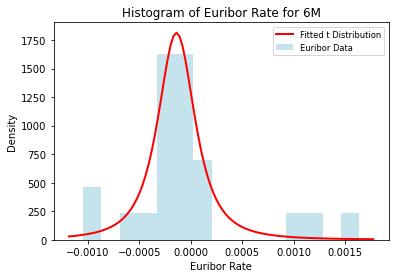

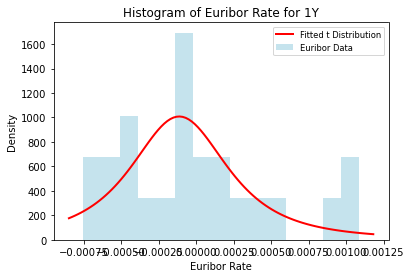

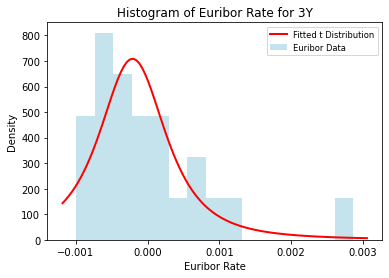

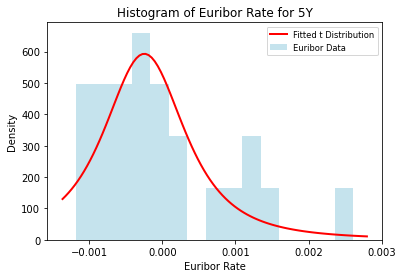

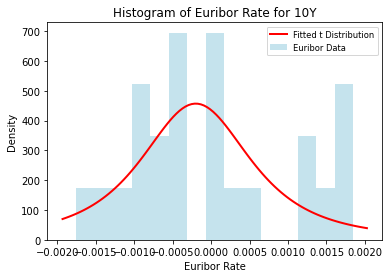

In [416]:
# Create an empty dataframe to store mean and standard deviation of estimates
fit_summary_t = pd.DataFrame(columns=["Maturity", "Mean", "Std_Dev", "df"])

# Iterate over each maturity
for maturity in euribor.columns[1:]:
    # Fit a t distribution to the Euribor data
    fit_params_t = stats.t.fit(res[maturity])
    
    # Summary of the fitted distribution
    print("Summary for", maturity)
    print("Mean:", fit_params_t[1])
    print("Standard Deviation:", fit_params_t[2])
    print("Degrees of Freedom:", fit_params_t[0])
    
    # Save mean, standard deviation, and degrees of freedom of estimates
    fit_summary_t = fit_summary_t.append({"Maturity": maturity, "Mean": fit_params_t[1], "Std_Dev": fit_params_t[2], "df": fit_params_t[0]}, ignore_index=True)
    
    # Plot histogram of Euribor data for the current maturity
    plt.figure()
    plt.hist(res[maturity], bins=15, color='lightblue', alpha=0.7, density=True)
    plt.title("Histogram of Euribor Rate for " + maturity)
    plt.xlabel("Euribor Rate")
    plt.ylabel("Density")
    
    # Plot fitted t distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.t.pdf(x, fit_params_t[0], fit_params_t[1], fit_params_t[2])
    plt.plot(x, p, 'red', linewidth=2)
    
    # Add legend with smaller text size
    plt.legend(["Fitted t Distribution", "Euribor Data"], loc="upper right", fontsize="small")

# View the summary of estimates for t distribution
print("Summary of Estimates for t distribution:")
print(fit_summary_t)


Summary of Estimates for Skew-Normal distribution:
  Maturity      Mean   Std_Dev
0       6M -0.000039  0.000573
1       1Y -0.000016  0.000515
2       3Y -0.000005  0.000843
3       5Y  0.000006  0.000923
4      10Y  0.000014  0.001036


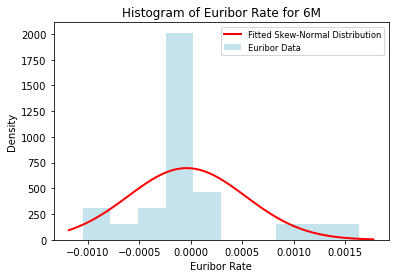

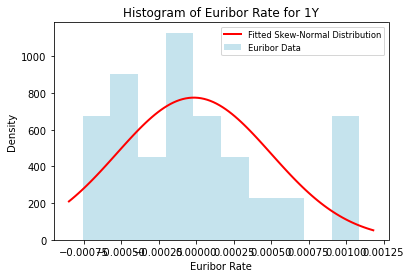

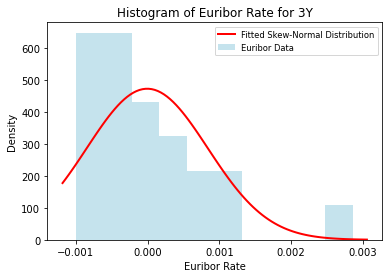

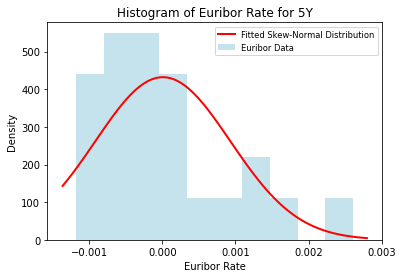

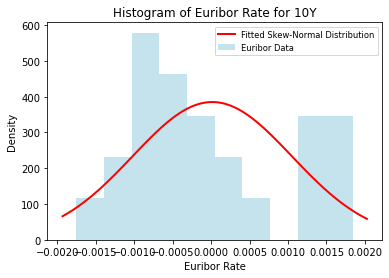

In [427]:
# Create an empty dataframe to store mean and standard deviation of estimates
fit_summary_skew = pd.DataFrame(columns=["Maturity", "Mean", "Std_Dev"])

# Iterate over each maturity
for maturity in euribor.columns[1:]:
    # Fit a skew-normal distribution to the Euribor data
    fit_params_skew = stats.norm.fit(res[maturity])
    
    # Summary of the fitted distribution
    #print("Summary for", maturity)
    #print("Mean:", fit_params_skew[0])
    #print("Standard Deviation:", fit_params_skew[2])
    #print("Skewness:", fit_params_skew[0])
    
    # Save mean, standard deviation, and skewness of estimates
    fit_summary_skew = fit_summary_skew.append({"Maturity": maturity, "Mean": fit_params_skew[0], "Std_Dev": fit_params_skew[1]}, ignore_index=True)
    
    # Plot histogram of Euribor data for the current maturity
    plt.figure()
    plt.hist(res[maturity], bins=10, color='lightblue', alpha=0.7, density=True)
    plt.title("Histogram of Euribor Rate for " + maturity)
    plt.xlabel("Euribor Rate")
    plt.ylabel("Density")
    
    # Plot fitted skew-normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, fit_params_skew[0], fit_params_skew[1])
    plt.plot(x, p, 'red', linewidth=2)
    
    # Add legend with smaller text size
    plt.legend(["Fitted Skew-Normal Distribution", "Euribor Data"], loc="upper right", fontsize="small")

# View the summary of estimates for skew-normal distribution
print("Summary of Estimates for Skew-Normal distribution:")
print(fit_summary_skew)


In [425]:
fit_params_skew

(-3.936465435955324e-05, 0.0005728506052993596)

### Simulate the next 5 years using skew normal distribution

Summary of Estimates for Skew-Normal distribution:
  Maturity      Mean   Std_Dev          Skew
0       6M -0.000613  0.000811  2.484664e+00
1       1Y -0.000724  0.000875  1.230510e+01
2       3Y -0.000992  0.001298  4.657245e+07
3       5Y -0.001177  0.001501  4.426970e+07
4      10Y -0.001265  0.001646  3.745284e+00


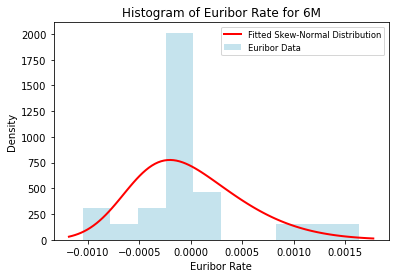

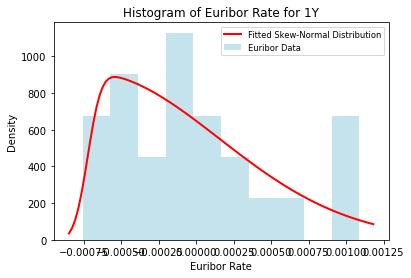

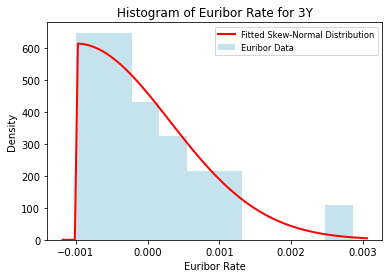

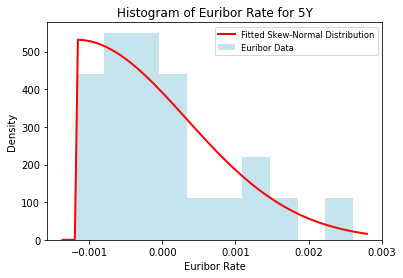

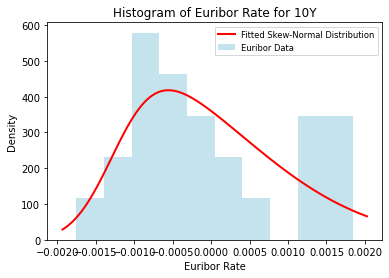

In [417]:
# Create an empty dataframe to store mean and standard deviation of estimates
fit_summary_skew = pd.DataFrame(columns=["Maturity", "Mean", "Std_Dev", "Skew"])

# Iterate over each maturity
for maturity in euribor.columns[1:]:
    # Fit a skew-normal distribution to the Euribor data
    fit_params_skew = stats.skewnorm.fit(res[maturity])
    
    # Summary of the fitted distribution
    #print("Summary for", maturity)
    #print("Mean:", fit_params_skew[1])
    #print("Standard Deviation:", fit_params_skew[2])
    #print("Skewness:", fit_params_skew[0])
    
    # Save mean, standard deviation, and skewness of estimates
    fit_summary_skew = fit_summary_skew.append({"Maturity": maturity, "Mean": fit_params_skew[1], "Std_Dev": fit_params_skew[2], "Skew": fit_params_skew[0]}, ignore_index=True)
    
    # Plot histogram of Euribor data for the current maturity
    plt.figure()
    plt.hist(res[maturity], bins=10, color='lightblue', alpha=0.7, density=True)
    plt.title("Histogram of Euribor Rate for " + maturity)
    plt.xlabel("Euribor Rate")
    plt.ylabel("Density")
    
    # Plot fitted skew-normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.skewnorm.pdf(x, fit_params_skew[0], fit_params_skew[1], fit_params_skew[2])
    plt.plot(x, p, 'red', linewidth=2)
    
    # Add legend with smaller text size
    plt.legend(["Fitted Skew-Normal Distribution", "Euribor Data"], loc="upper right", fontsize="small")

# View the summary of estimates for skew-normal distribution
print("Summary of Estimates for Skew-Normal distribution:")
print(fit_summary_skew)


In [444]:

# Fit the skew-normal distribution to your data
fit_params = skewnorm.fit(res['6M'])

# Perform the KS test
statistic, p_value = kstest(res['6M'], 'skewnorm', fit_params)

# Print the results
print("KS Statistic:", statistic)
print("P-value:", p_value)

KS Statistic: 0.24429474637696036
P-value: 0.09550934282659718


In [203]:
import numpy as np
from scipy.stats import skewnorm

# Define the number of years for simulation
years = 5
# Define the number of periods per year (e.g., monthly data)
periods_per_year = 12
# Total number of periods for simulation
total_periods = years * periods_per_year

# Initialize an empty dictionary to store simulated rates for each maturity
simulated_rates = {}

# Iterate over each maturity
for maturity, row in fit_summary_skew.iterrows():
    # Extract parameters for the current maturity
    mean = row['Mean']
    std_dev = row['Std_Dev']
    skewness = row['Skew']
    
    # Generate random samples from the skew-normal distribution
    samples = skewnorm.rvs(skewness, loc=mean, scale=std_dev, size=total_periods)
    
    # Save the simulated rates for the current maturity
    simulated_rates[maturity] = samples



In [204]:
# Convert the dictionary of arrays to a DataFrame
simulated_rates_df = pd.DataFrame(simulated_rates)
# Define new column names
new_column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Change column names
simulated_rates_df.columns = new_column_names
# Display the DataFrame
print(simulated_rates_df)

          6M        1Y        3Y        5Y       10Y
0  -0.002011 -0.003151  0.014507 -0.003372  0.011637
1  -0.004900 -0.001358 -0.003305  0.005273  0.008906
2  -0.002369  0.006850  0.010535 -0.002159  0.012695
3  -0.002814  0.005466 -0.005106  0.003989  0.002327
4   0.006632  0.002934 -0.002031  0.007071 -0.000802
5   0.002055  0.003335 -0.001088  0.001557  0.012359
6  -0.003106  0.007503  0.001125 -0.001381  0.017735
7  -0.003629  0.003070 -0.001629  0.002703  0.014271
8  -0.000067 -0.003662  0.001926  0.004249 -0.000472
9   0.001962  0.003428  0.004637  0.004143  0.010624
10 -0.001804 -0.004550 -0.002754  0.002606  0.005870
11 -0.002880  0.003417 -0.004005 -0.001165  0.009495
12  0.002027  0.012713  0.007528  0.002366  0.013453
13  0.012869 -0.001269  0.010820  0.004967 -0.000637
14 -0.004319 -0.002869 -0.002473 -0.002451  0.005299
15  0.006710  0.003911  0.004122 -0.003046  0.006852
16 -0.000937  0.001858 -0.003467  0.002883  0.006896
17 -0.004422  0.004740  0.006733  0.000759  0.

Summary for 6M
Shape: 0.13542632507598568
Scale: 2.0382162596708615
Summary for 1Y
Shape: 2.2086035332244713
Scale: 0.00037087631015755797
Summary for 3Y
Shape: 0.40226434978550485
Scale: 0.0018376283139880526
Summary for 5Y
Shape: 1.5217598092690978
Scale: 0.0008043756214619871
Summary for 10Y
Shape: 5.59489361980069
Scale: 0.00044946345132034296
Summary of Estimates for Gamma distribution:
  Maturity     Shape     Scale
0       6M  0.135426  2.038216
1       1Y  2.208604  0.000371
2       3Y  0.402264  0.001838
3       5Y  1.521760  0.000804
4      10Y  5.594894  0.000449


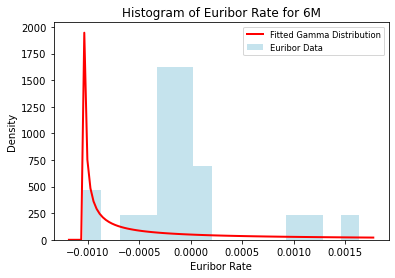

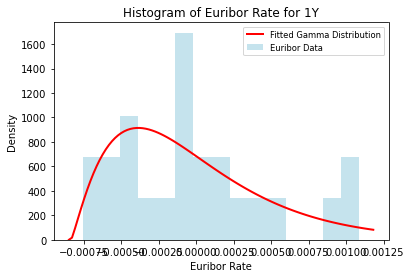

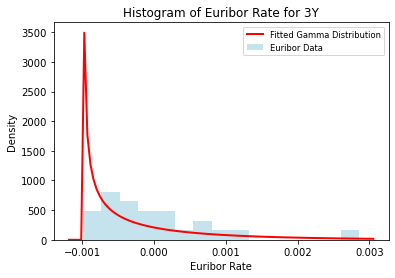

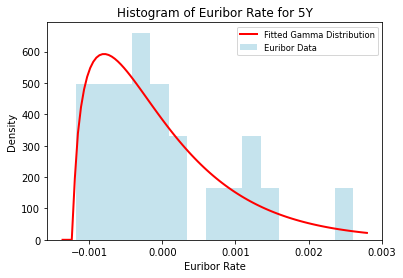

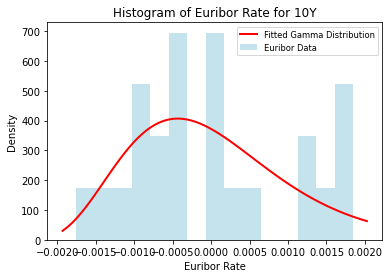

In [418]:
# Create an empty dataframe to store shape and scale parameters for each maturity
fit_summary_gamma = pd.DataFrame(columns=["Maturity", "Shape", "Scale"])

# Iterate over each maturity
for maturity in euribor.columns[1:]:
    # Fit a gamma distribution to the Euribor data
    shape, loc, scale = stats.gamma.fit(res[maturity])
    
    # Summary of the fitted distribution
    print("Summary for", maturity)
    print("Shape:", shape)
    print("Scale:", scale)
    
    # Save shape and scale parameters of estimates
    fit_summary_gamma = fit_summary_gamma.append({"Maturity": maturity, "Shape": shape, "Scale": scale}, ignore_index=True)
    
    # Plot histogram of Euribor data for the current maturity
    plt.figure()
    plt.hist(res[maturity], bins=15, color='lightblue', alpha=0.7, density=True)
    plt.title("Histogram of Euribor Rate for " + maturity)
    plt.xlabel("Euribor Rate")
    plt.ylabel("Density")
    
    # Generate x values for plotting the fitted gamma distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    
    # Calculate the fitted gamma distribution
    gamma_dist = stats.gamma.pdf(x, shape, loc, scale)
    
    # Plot the fitted gamma distribution
    plt.plot(x, gamma_dist, 'red', linewidth=2)
    
    # Add legend with smaller text size
    plt.legend(["Fitted Gamma Distribution", "Euribor Data"], loc="upper right", fontsize="small")

# View the summary of estimates for gamma distribution
print("Summary of Estimates for Gamma distribution:")
print(fit_summary_gamma)


In [430]:
from scipy.stats import gamma, skewnorm
import numpy as np
for i in range(0,5):
    # Assuming your data is stored in 'data'
    data = res.iloc[:,i]

    # Fit gamma distribution
    params_gamma = gamma.fit(data)

    # Fit skew-normal distribution
    params_skewnorm = skewnorm.fit(data)

    params_t=t.fit(data)
    
    params_norm= stats.norm.fit(data)
    
    # Calculate AIC or BIC for gamma distribution
    aic_gamma = -2 * gamma.logpdf(data, *params_gamma).sum() + 2 * len(params_gamma)

    # Calculate AIC or BIC for skew-normal distribution
    aic_skewnorm = -2 * skewnorm.logpdf(data, *params_skewnorm).sum() + 2 * len(params_skewnorm)
    
    aic_t = -2 * t.logpdf(data, *params_gamma).sum() + 2 * len(params_gamma)

    aic_norm = -2 * stats.norm.logpdf(data, *params_norm).sum() + 2 * len(params_gamma)

    
    # Compare AIC or BIC values
    if aic_gamma < aic_skewnorm:
        print("Gamma distribution is a better fit.")
    else:
        print("Skew-normal distribution is a better fit.")
        
    print(aic_gamma, aic_skewnorm, aic_t, aic_norm)


Skew-normal distribution is a better fit.
-248.47796918697955 -288.2635548080083 125.61073413275689 -284.2054591572024
Skew-normal distribution is a better fit.
-294.1517311322326 -294.32397444460014 -239.08593051142245 -289.32177486368096
Gamma distribution is a better fit.
-302.4641510281989 -278.2024416803812 -211.20601909469565 -265.65506303159594
Skew-normal distribution is a better fit.
-270.1437154502682 -271.23182854032063 -230.81080284354235 -261.28336807017774
Skew-normal distribution is a better fit.
-257.51445578621895 -257.832169103909 -33.737280604720375 -255.77574262925538


In [112]:
print("Mean MSE DNS:", min_mse)
print(f"The mean MSE RW",MSE2)
print("Average MSE Vasicek:", avg_mse)
print("Average MSE Vasicek MLE:", mse_vasi_paper)

Mean MSE DNS: 2.416352429879821e-05
The mean MSE RW 1.7933831296296298e-05
Average MSE Vasicek: 2.378095216320352e-05
Average MSE Vasicek MLE: 1.5836970102142208e-05


In [40]:
df=df.set_index(test_data.index)

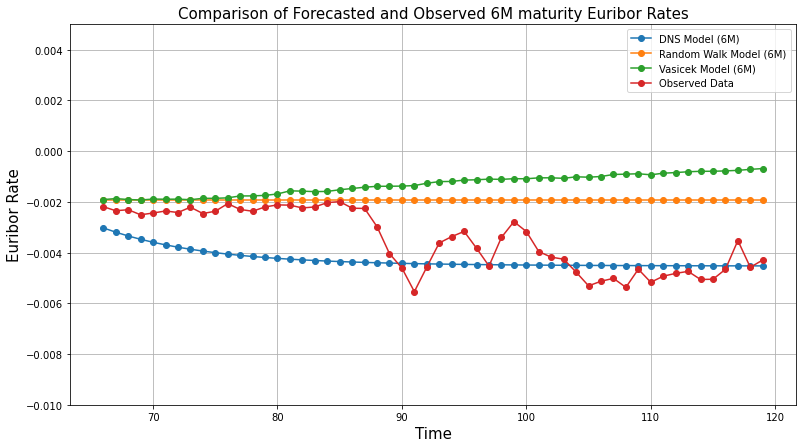

In [41]:
y_RW_6M = forecast_results_df.iloc[1,53]
y_RW_6M_df = pd.DataFrame(y_RW_6M, index=test_data.index, columns=['1Y Random Walk'])
y_NS_6M = y['1Y']
y_VAS_6M = df['1Y']
y_org = euribor.iloc[-54:,2]
# Plotting
plt.figure(figsize=(13, 7))
plt.plot(y_NS_6M, label='DNS Model (6M)', marker='o')
plt.plot(y_RW_6M_df, label='Random Walk Model (6M)', marker='o')
plt.plot(y_VAS_6M, label='Vasicek Model (6M)', marker='o')
plt.plot(y_org, label='Observed Data', marker='o')
plt.ylim(-0.010, 0.005)
plt.title('Comparison of Forecasted and Observed 6M maturity Euribor Rates', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Euribor Rate', fontsize=15)
plt.legend()
plt.grid(True)
plt.savefig('forecast_yield.png')
plt.show()